# Model Fitting: ESS (Elliptical Slice Sampling) for a single game

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np
import cPickle as pickle
# import pickle as pickle

In [4]:
player_info = pd.read_csv("clean-data/player_info_pergame.csv")
game_outcomes = pd.read_csv("clean-data/game_outcomes_15-16.csv")

In [5]:
with open("clean-data/host_team_line_up.pkl", "rb") as f:
    host_team_line_up = pickle.load(f)

with open("clean-data/guest_team_line_up.pkl", "rb") as f:
    guest_team_line_up = pickle.load(f)

In [6]:
################# INPUT SECTION ###################
###################################################

########### player indicator for each game ###############
### host_lineup_arr & guest_lineup_arr are (1230 x 476)###
with open("clean-data/host_team_line_up.pkl", "rb") as f:
    host_team_line_up = pickle.load(f)

with open("clean-data/guest_team_line_up.pkl", "rb") as f:
    guest_team_line_up = pickle.load(f)
    
# print len(host_team_line_up[0])
host_lineup_arr = np.array(host_team_line_up)
guest_lineup_arr = np.array(guest_team_line_up)


######### team indicator for each game ########### 
### host_matrix & guest_matrix are (1230 x 30) ###
guest_matrix = np.zeros((game_outcomes.shape[0], np.max(game_outcomes['Visitor_Index']) + 1), dtype = bool)
guest_matrix.shape
host_matrix = np.copy(guest_matrix)

def make_matrix(mat, indices):
    for (i, ind) in enumerate(indices):
        mat[i, ind] = True

make_matrix(host_matrix, game_outcomes['Visitor_Index'].values)
make_matrix(guest_matrix, game_outcomes['Home_Index'].values)


############## Observed data ##################
score_diff = game_outcomes['diff'].values
off_rating = player_info['PTS'].values + player_info['AST'].values
def_rating = player_info['BLK'].values + player_info["STL"].values + player_info['DRB'].values

In [7]:
# ortg_values = player_info['ORtg'].values
# drtg_values = player_info['DRtg'].values
# score_diff = game_outcomes['diff'].values

def diff_score_calc(f_guest, f_host, game_index):
    # f_i is the state of the latent variables: the vector 'beta' for team2 and the vector 'gamma' for team2
    guest_i = guest_team_line_up[game_index]
    host_i = host_team_line_up[game_index]
    
    guest_diff = (f_guest[0] + off_rating[guest_i].dot(f_guest[1:])) - (f_host[0] + def_rating[host_i].dot(f_host[1:]))
    host_diff = (f_host[0] + off_rating[host_i].dot(f_host[1:])) - (f_guest[0] + def_rating[guest_i].dot(f_guest[1:]))
    return guest_diff - host_diff    

In [8]:
# log likelihood for standard Gaussian
def log_likelihood(f_guest, f_host, game_index):
    new_mean = diff_score_calc(f_guest, f_host, game_index)    
    return scipy.stats.norm.logpdf(score_diff[game_index], new_mean, 10.0)

In [9]:
def covariance(dim, gammaMean = 1.0, gammaScale = 1.0):
    mat = np.identity(dim)
    for i in np.arange(dim):
        for j in np.arange(dim):
            if (i == j):
                continue
            mat[i,j] = np.random.gamma(gammaMean, gammaScale, size=None)
    return mat
# print correlation()[2*N_teams + N_players][2 * N_teams + N_players:2 * N_teams + N_players +N_players]

In [10]:
mvn = np.random.multivariate_normal
def ess(game_index, log_likelihood, N_mcmc, burn_in):
    ## 1 indicates 'guest'
    ## 2 indicates 'host'
    N_1 = len(player_info[guest_team_line_up[game_index]]) + 1
    N_2 = len(player_info[host_team_line_up[game_index]]) + 1
    
    # INITIALIZATION
    # the combined latent variable states: first half is for the home team and the rest for the guest
    mcmc_samples_1 = np.random.randn(N_mcmc + burn_in, N_1)
    mcmc_samples_2 = np.random.randn(N_mcmc + burn_in, N_2)
    
    # random draw from normal distribution with which we'll determine
    # new state of the latent variables
    norm_samples_1 = mvn(np.zeros(N_1), covariance(N_1), N_mcmc + burn_in)
    norm_samples_2 = mvn(np.zeros(N_2), covariance(N_2), N_mcmc + burn_in)
    
    # random draw from unifrom distribution with which we'll determine 
    # the loglikelihood threshold (likelihood threshold defines the 'slice' where we sample)
    unif_samples = np.random.uniform(0, 1, N_mcmc+burn_in)
    
    # initial proposal of the theta
    theta = np.random.uniform(0, 2*np.pi, N_mcmc+burn_in)
    
    # variables with which we'll propose a new state by shrinking the range of theta
    theta_min = theta - 2*np.pi
    theta_max = theta + 2*np.pi
    
    # We select a new location (i.e. new state of the latent variables)
    # on the randomly generated ellipse given theta and norm_samples
    for i in range(1, N_mcmc + burn_in):
#         if i % 100 == 0:
#             print i

        # initial state of the latent vairables    
        f_1 = mcmc_samples_1[i - 1,:]
        f_2 = mcmc_samples_2[i - 1,:]
        #print f, data
        
        # the loglikelihood threshold
        # the threshold is chosen between [0, Likelihood]
        llh_thresh = log_likelihood(f_1, f_2, game_index) + np.log(unif_samples[i])
        
        f_prime_1 = (f_1 * np.cos(theta[i])) + (norm_samples_1[i,:] * np.sin(theta[i]))
        f_prime_2 = (f_2 * np.cos(theta[i])) + (norm_samples_2[i,:] * np.sin(theta[i]))
        while log_likelihood(f_prime_1, f_prime_2, game_index) < llh_thresh:
            if theta[i] < 0:
                theta_min[i] = theta[i]
            else:
                theta_max[i] = theta[i]
                
            theta[i] = np.random.uniform(theta_min[i], theta_max[i], 1)  
            f_prime_1 = (f_1 * np.cos(theta[i])) + (norm_samples_1[i,:]*np.sin(theta[i]))
            f_prime_2 = (f_2 * np.cos(theta[i])) + (norm_samples_2[i,:]*np.sin(theta[i]))
            
        mcmc_samples_1[i,:] = f_prime_1
        mcmc_samples_2[i,:] = f_prime_2
    
    return mcmc_samples_1[(burn_in+1):(burn_in+N_mcmc),], mcmc_samples_2[(burn_in+1):(burn_in+N_mcmc),]

# Estimation of the states of the latent variables for Guest & Host in a certain game

In [11]:
game_index = 10
N_mcmc = 40000
burn_in = 2000
guest_states, host_states = ess(game_index, log_likelihood, N_mcmc, burn_in)
# print guest_states
# print guest_states.shape

mean_g = guest_states.mean(axis=0)
mean_h =  host_states.mean(axis=0)
print mean_g, mean_g.shape
print mean_h, mean_h.shape

real = score_diff[game_index]
estimated = diff_score_calc(mean_g, mean_h, game_index)
print 'the actual differential score = %s' %(real)
print 'the differential score with the estimated variable states = %s' %(estimated)
print 'difference is %s percent' %(np.fabs(real - estimated)*100.0/real)

[ 0.06129953  0.05267597  0.02317751  0.04618529  0.02630109 -0.01484916
  0.07808274  0.03570481  0.08039215  0.05481546  0.06843264  0.01625506
  0.06131104  0.04536169  0.02422032 -0.02972719] (16L,)
[-0.09213031 -0.08894079 -0.06719097 -0.04294472 -0.12655498 -0.05106033
 -0.09009468 -0.07310243 -0.08550934 -0.11481652 -0.06314864 -0.07950521
 -0.07424085 -0.09519198 -0.07823043] (15L,)
the actual differential score = 25.0
the differential score with the estimated variable states = 25.0071453664
difference is 0.0285814655069 percent


D:\Users\Jim Hyungmok Son\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: covariance is not positive-semidefinite.
D:\Users\Jim Hyungmok Son\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: covariance is not positive-semidefinite.


# Convergence test through MAP estimation
* The result for one player is shown

The MAP value for beta 10 is: -0.60930153813


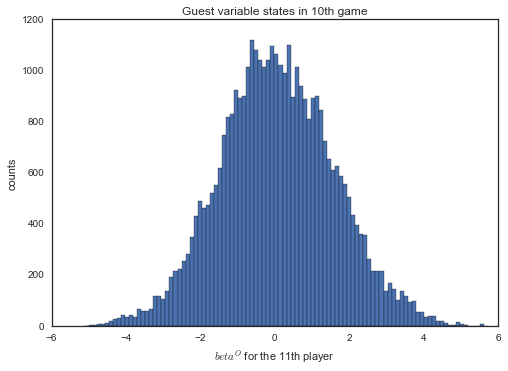

In [25]:
for i in range(10,11):
    plt.figure(i)
    p_hist = plt.hist(guest_states[burn_in:,i], bins=100)
    plt.title("Guest variable states in %sth game" %(game_index))
    plt.xlabel("$beta^{O}$ for the %sth player" %(i+1))0.66
    plt.ylabel("counts")
    p_map_index = np.argmax(p_hist[0])
    p_hist_bin_middle = 0.5*p_hist[1][:-1] + 0.5*p_hist[1][1:]
    p_map = p_hist_bin_middle[p_map_index]
    
    print "The MAP value for beta %s is: %s" %(i, p_map)

The MAP value for beta 10 is: 0.171178789071


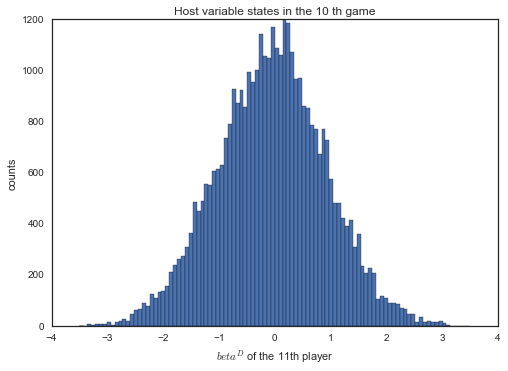

In [24]:
for i in range(10,11):
    plt.figure(i)
    p_hist = plt.hist(host_states[burn_in:,i], bins=100)
    plt.title("Host variable states in the %s th game" %(game_index))
    plt.xlabel("$beta^{D}$ of the %sth player" %(i+1))
    plt.ylabel("counts")
    p_map_index = np.argmax(p_hist[0])
    p_hist_bin_middle = 0.5*p_hist[1][:-1] + 0.5*p_hist[1][1:]
    p_map = p_hist_bin_middle[p_map_index]
    
    print "The MAP value for beta %s is: %s" %(i, p_map)

* When we apply ESS for a single game, the states of the latent variable seem to converge nicely. In this case, even the differential scoer between the two teams calculated based on the estimated state values agrees pretty well with the observed data: for instance, the difference between the estimation and the actual observation is 0.07 percent in the 10th game.